# Post hoc calibration by Temperature and Platt scaling of the Perch v2 model on BirdSet

In [1]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8")

In [2]:
from uncertainbird.utils.misc import load_data
from uncertainbird.modules.models.audioprotopnet import AudioProtoPNet

log_dir = "/workspace/logs/predictions/audioprotopnet"
data, predictions, targets, valid_keys = load_data(log_dir, load_logits=True)
model = AudioProtoPNet()
model_name = 'AudioProtoPNet'

/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Loaded data with 23756 samples
Predictions shape: torch.Size([23756, 9736])
Targets shape: torch.Size([23756, 9736])
Loaded data with 205200 samples
Predictions shape: torch.Size([205200, 9736])
Targets shape: torch.Size([205200, 9736])
Loaded data with 36637 samples
Predictions shape: torch.Size([36637, 9736])
Targets shape: torch.Size([36637, 9736])


/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
from uncertainbird.utils.misc import prune_non_target_classes

data = prune_non_target_classes(data, targets)

# Temperature scaling on POW validation set

In [4]:
from uncertainbird.utils.temperature_scaling import (
    fit_global_temperature,
    apply_temperature_scaling,
)
class_index = 10
data_POW = data

# compute global temperature value based on POW
temperature = fit_global_temperature(
    data_POW["POW"]["logits"], data_POW["POW"]["targets"], 1000, lr=0.001
)

print(f"Optimal temperature: {temperature:.3f}")

# apply temperature scaling to all test datasets
for dataset_name in valid_keys:

    data_POW[dataset_name]["predictions_ts"] = apply_temperature_scaling(
        data_POW[dataset_name]["logits"], temperature, model= model
    )

Optimal temperature: 0.418


Dataset: HSN
Before temperature scaling:


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.buc

Accuracy: tensor(0.9989)
cmAP: tensor(0.5553)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0062)
ECE Weighted: tensor(0.1029)
ECE Top-3: tensor(0.0977)
ECE Top-5: tensor(0.0966)
ECE Top-10: tensor(0.1122)
ECE Top-21: tensor(0.1210)
Miscalibration Score (MCS): tensor(0.0114)
ECE Under-confidence: tensor(0.0457)
ECE Over-confidence: tensor(0.0571)
After temperature scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5553)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0013)
ECE Weighted: tensor(0.0943)
ECE Top-3: tensor(0.0944)
ECE Top-5: tensor(0.0685)
ECE Top-10: tensor(0.0399)
ECE Top-21: tensor(0.0251)
Miscalibration Score (MCS): tensor(-0.0923)
ECE Under-confidence: tensor(0.0933)
ECE Over-confidence: tensor(0.0010)
Dataset: NBP
Before temperature scaling:
Accuracy: tensor(0.9967)
cmAP: tensor(0.6574)
Precision: tensor(0.0937)
Recall: tensor(0.0302)
F1 Score: 

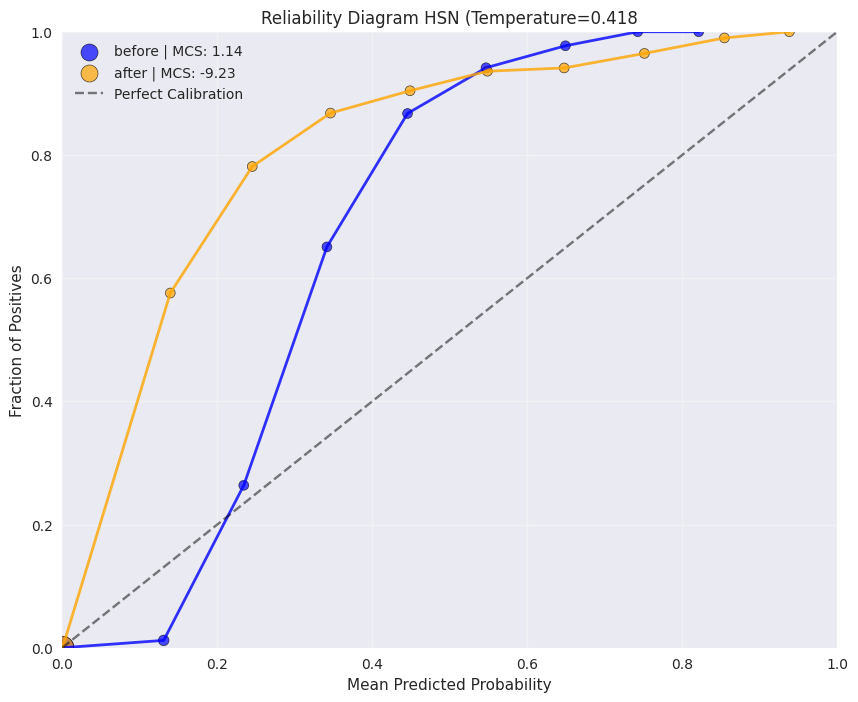

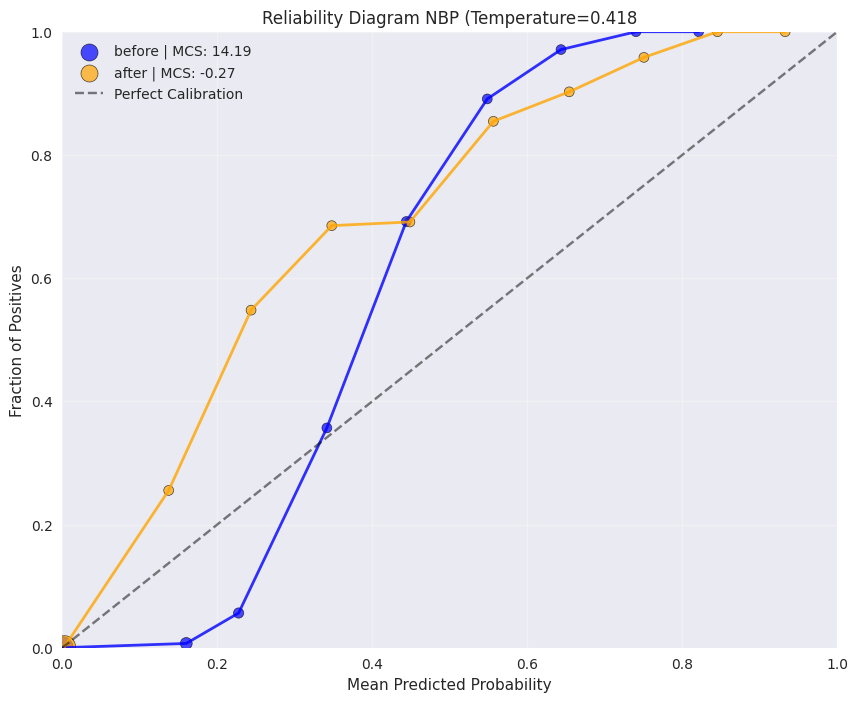

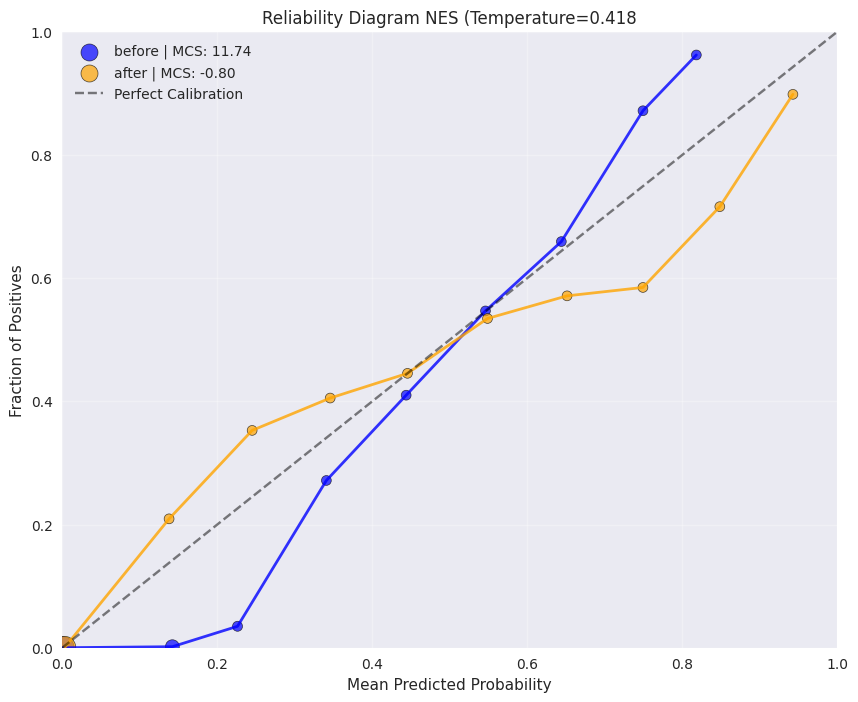

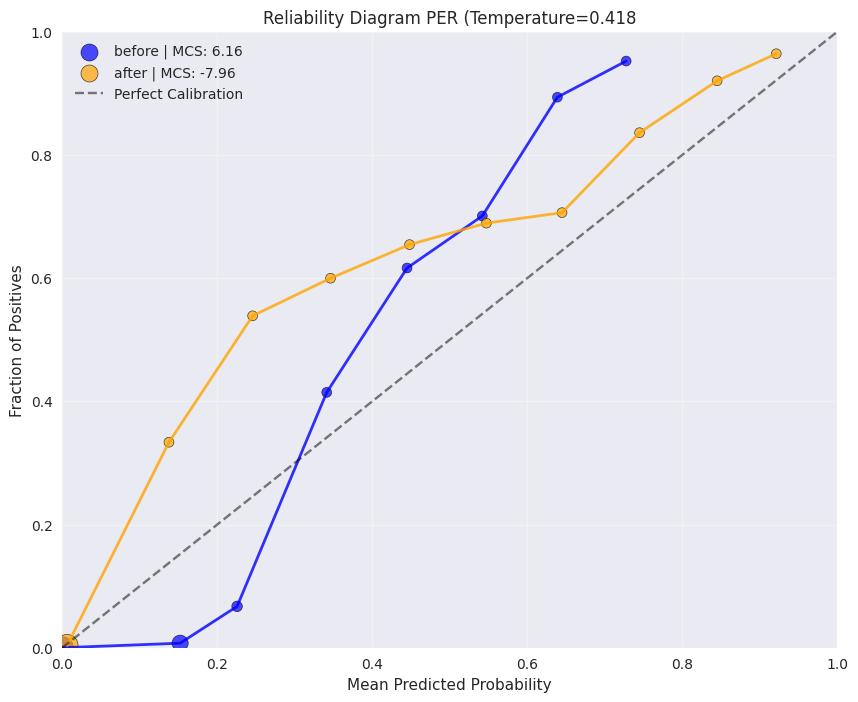

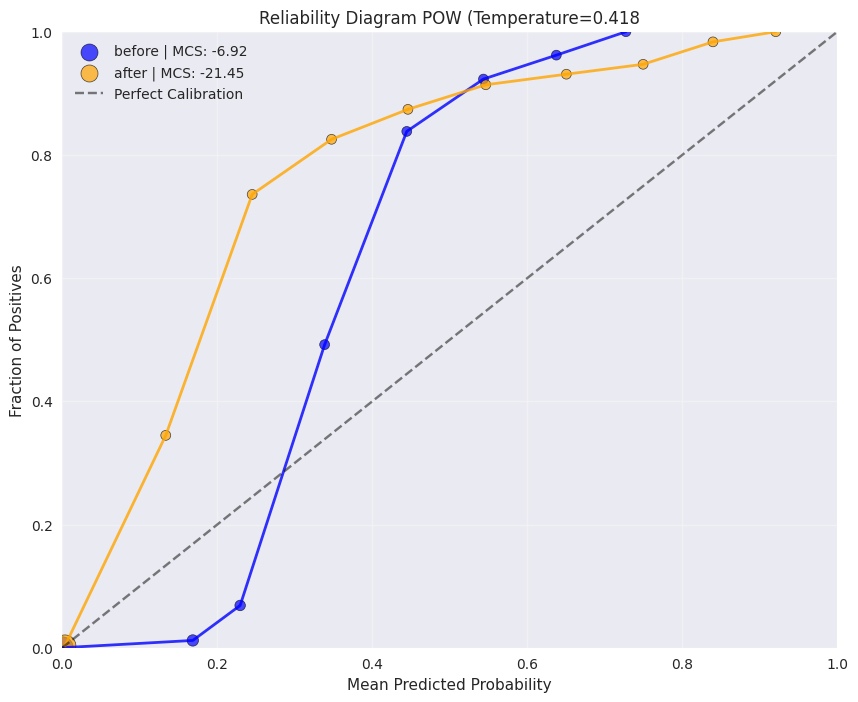

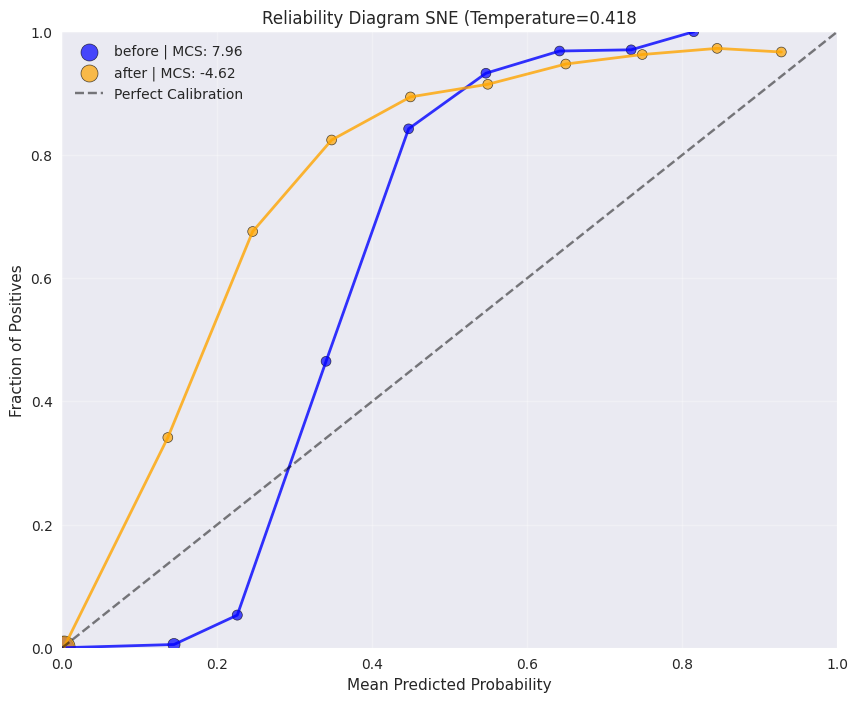

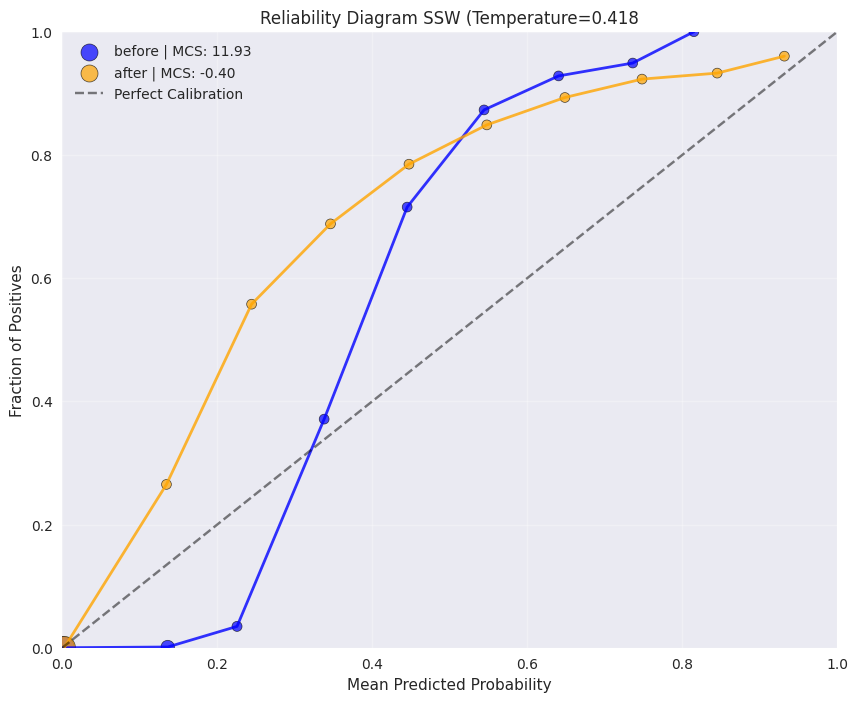

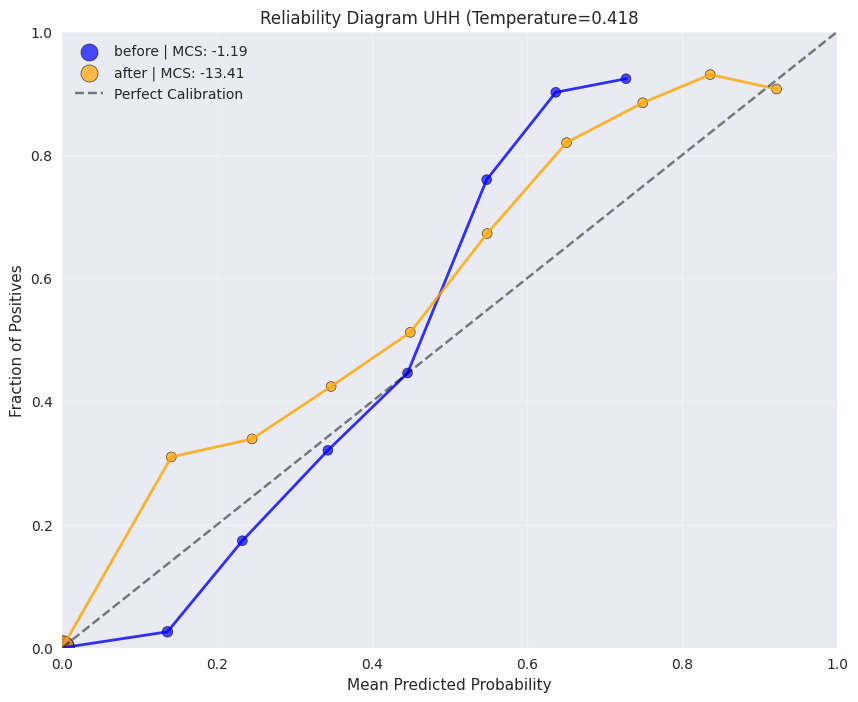

In [5]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    print("Dataset:", dataset_name)
    print("Before temperature scaling:")
    data_POW[dataset_name]["metrics"] = print_metrics(
        data_POW[dataset_name]["predictions"], data_POW[dataset_name]["targets"]
    )
    print("After temperature scaling:")
    data_POW[dataset_name]["metrics_ts"] = print_metrics(
        data_POW[dataset_name]["predictions_ts"], data_POW[dataset_name]["targets"]
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data_POW[dataset_name]["predictions"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "blue",
            "metrics": data_POW[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data_POW[dataset_name]["predictions_ts"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "orange",
            "metrics": data_POW[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram {dataset_name} (Temperature={temperature:.3f}",
    )

# Platt scaling on POW validation set

In [6]:
from uncertainbird.utils.temperature_scaling import (
    fit_global_platt_scaling,
    apply_platt_scaling
)
class_index = 10
data_POW = data

# compute global temperature value based on POW
slope, bias = fit_global_platt_scaling(
    data_POW["POW"]["logits"], data_POW["POW"]["targets"], 1000, lr=0.01
)

print(f"Optimal slope: {slope:.3f}, bias: {bias:.3f}")

# apply temperature scaling to all test datasets
for dataset_name in valid_keys:

    data_POW[dataset_name]["predictions_ts"] = apply_platt_scaling(
        data_POW[dataset_name]["logits"], slope, bias, model= model
    )

Optimal slope: 4.687, bias: 2.923


Dataset: HSN
Before platt scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5553)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0062)
ECE Weighted: tensor(0.1029)
ECE Top-3: tensor(0.0977)
ECE Top-5: tensor(0.0966)
ECE Top-10: tensor(0.1122)
ECE Top-21: tensor(0.1210)
Miscalibration Score (MCS): tensor(0.0114)
ECE Under-confidence: tensor(0.0457)
ECE Over-confidence: tensor(0.0571)
After temperature scaling:
Accuracy: tensor(0.9991)
cmAP: tensor(0.5553)
Precision: tensor(0.0318)
Recall: tensor(0.0176)
F1 Score: tensor(0.0192)
AUROC: tensor(0.0474)
ECE: tensor(0.0009)
ECE Weighted: tensor(0.0793)
ECE Top-3: tensor(0.0825)
ECE Top-5: tensor(0.0623)
ECE Top-10: tensor(0.0336)
ECE Top-21: tensor(0.0185)
Miscalibration Score (MCS): tensor(-0.0786)
ECE Under-confidence: tensor(0.0790)
ECE Over-confidence: tensor(0.0003)
Dataset: NBP
Before platt scaling:
Accuracy: tensor(0.9967)
cmAP: tensor(0.6574)
Precision: tensor(0.0937)
Reca

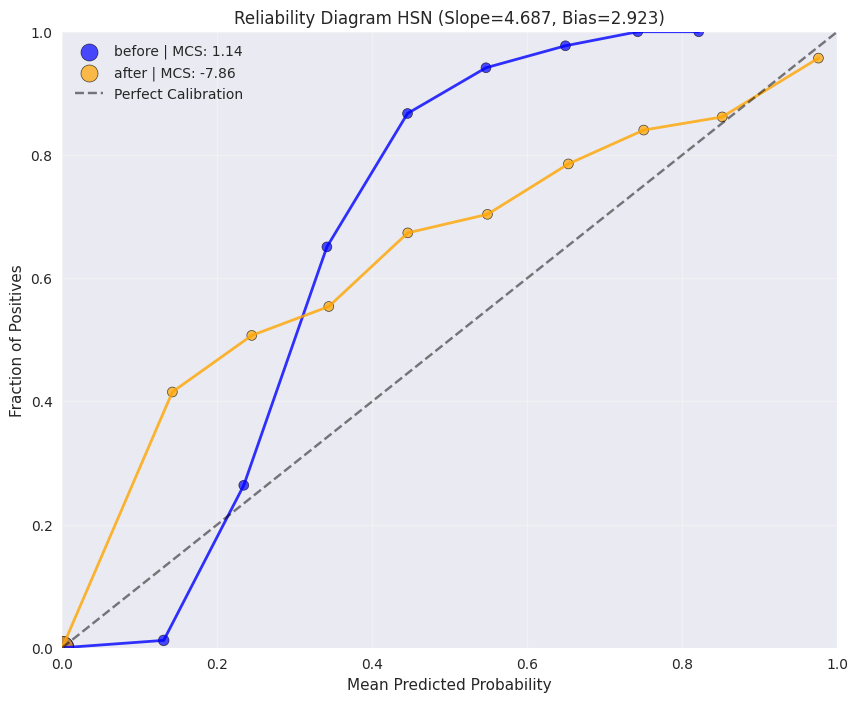

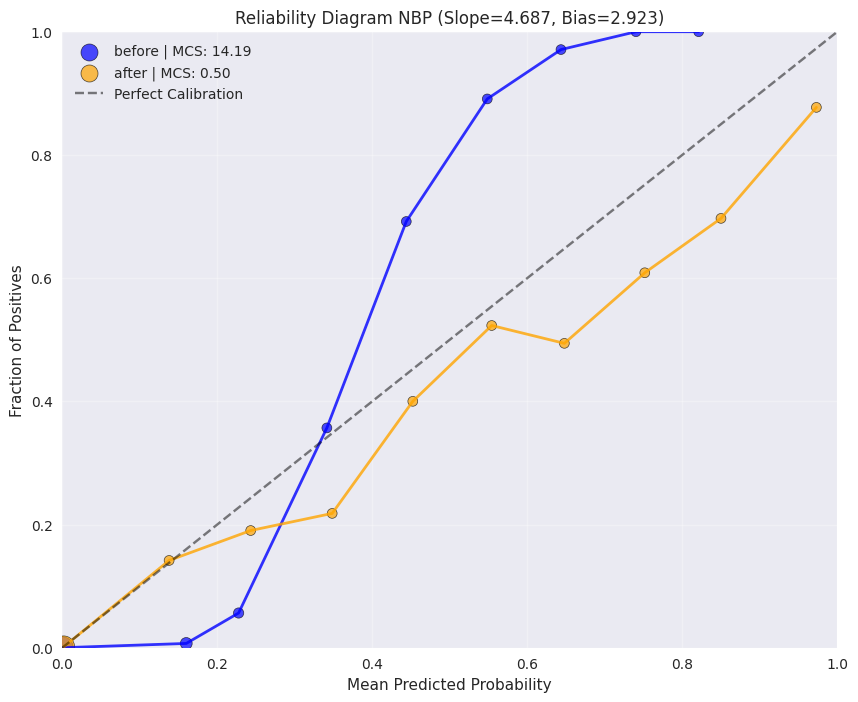

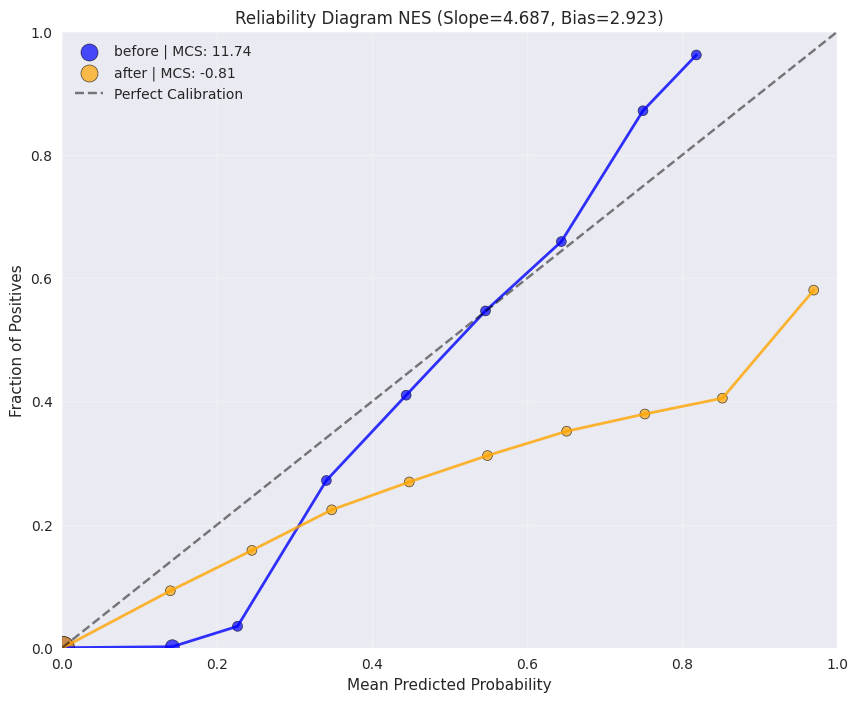

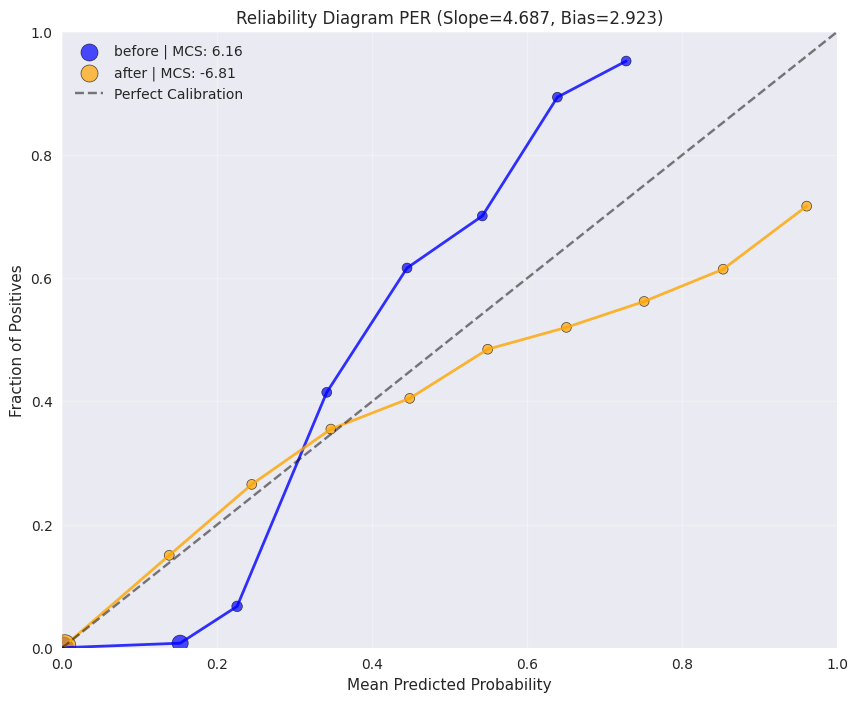

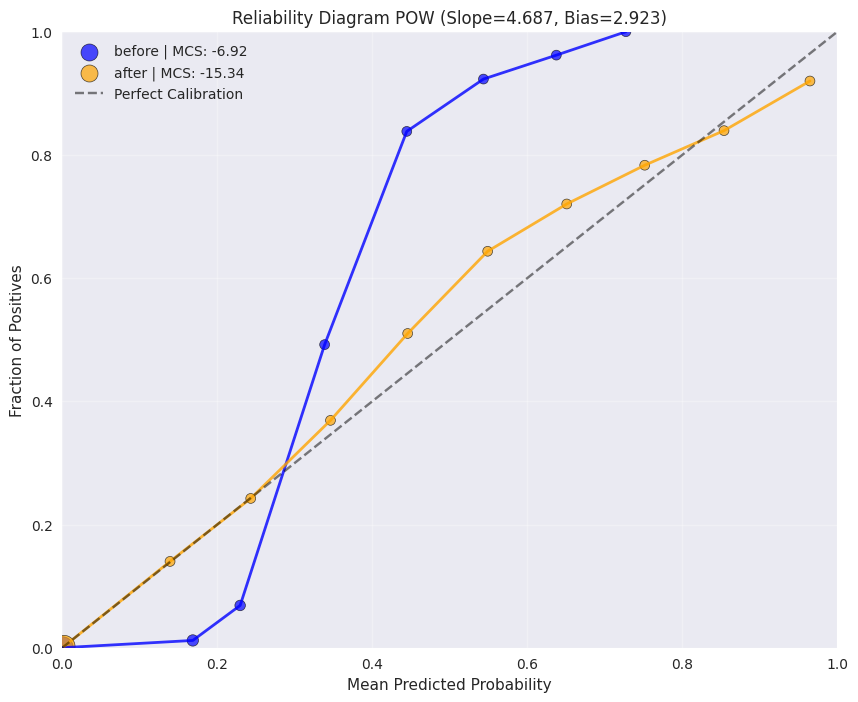

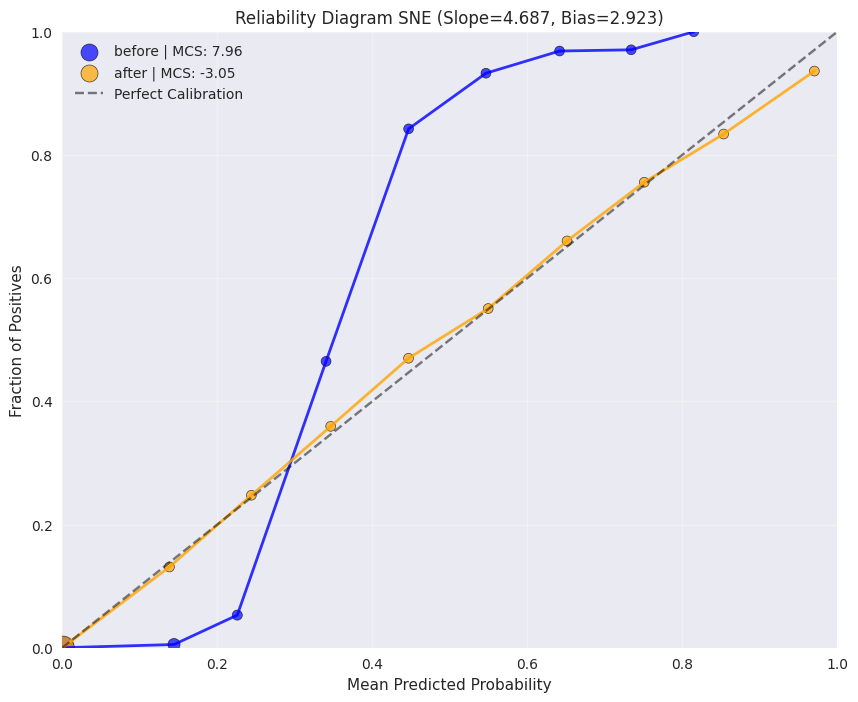

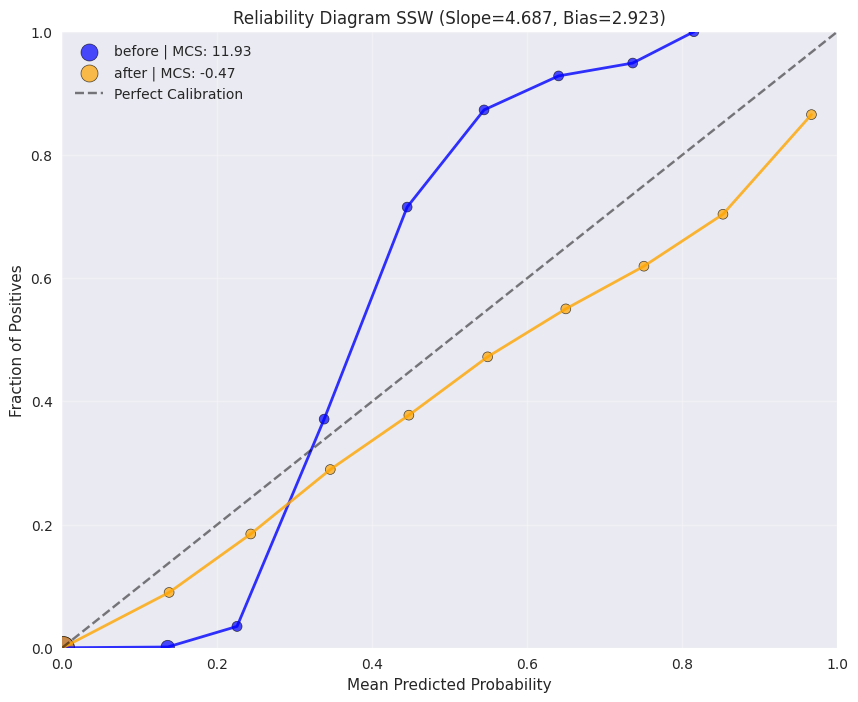

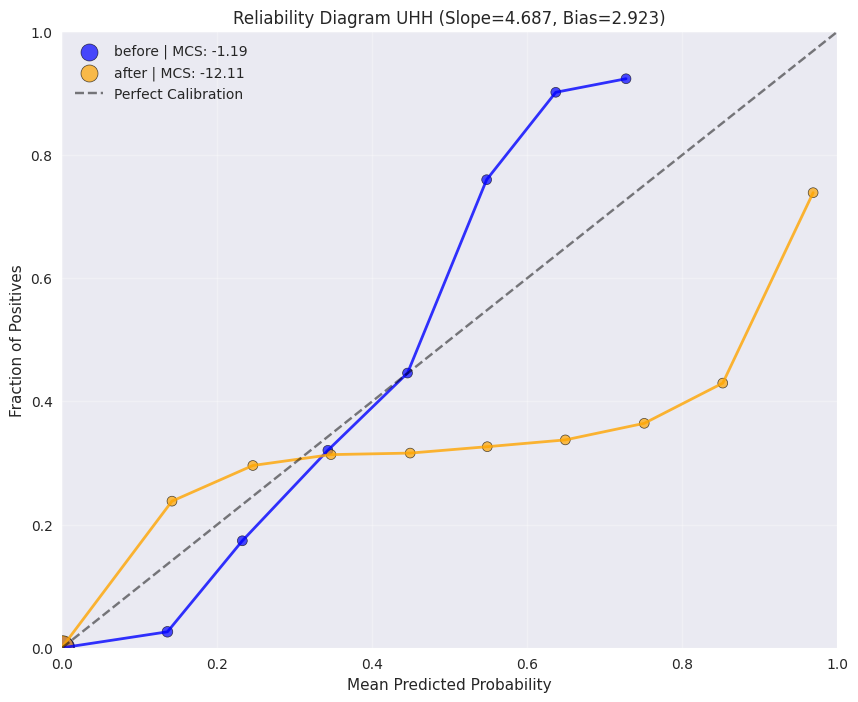

In [7]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    print("Dataset:", dataset_name)
    print("Before platt scaling:")
    data_POW[dataset_name]["metrics"] = print_metrics(
        data_POW[dataset_name]["predictions"], data_POW[dataset_name]["targets"]
    )
    print("After temperature scaling:")
    data_POW[dataset_name]["metrics_ts"] = print_metrics(
        data_POW[dataset_name]["predictions_ts"], data_POW[dataset_name]["targets"]
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data_POW[dataset_name]["predictions"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "blue",
            "metrics": data_POW[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data_POW[dataset_name]["predictions_ts"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "orange",
            "metrics": data_POW[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram {dataset_name} (Slope={slope:.3f}, Bias={bias:.3f})",
    )

# Using a porton of the test data

In [8]:
from uncertainbird.utils.misc import slit_based_on_first_n_samples

# 10min of audio per class -> 120 samples of 5s each
data_120 = slit_based_on_first_n_samples(data, n=120)

## Global parameters for all classes

### Temperature scaling

In [9]:
for ds in valid_keys:

    # compute global temperature value based on POW
    temperature = fit_global_temperature(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    print(f"Optimal temperature: {temperature:.3f} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_temperature_scaling(
        data_120[ds+'_test']["logits"], temperature, model= model
    )
    print('Before temperature scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After temperature scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Optimal temperature: 0.437 for HSN
Before temperature scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5552)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0062)
ECE Weighted: tensor(0.1029)
ECE Top-3: tensor(0.0978)
ECE Top-5: tensor(0.0967)
ECE Top-10: tensor(0.1122)
ECE Top-21: tensor(0.1210)
Miscalibration Score (MCS): tensor(0.0113)
ECE Under-confidence: tensor(0.0458)
ECE Over-confidence: tensor(0.0571)
After temperature scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5552)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0014)
ECE Weighted: tensor(0.0929)
ECE Top-3: tensor(0.0926)
ECE Top-5: tensor(0.0667)
ECE Top-10: tensor(0.0403)
ECE Top-21: tensor(0.0265)
Miscalibration Score (MCS): tensor(-0.0904)
ECE Under-confidence: tensor(0.0917)
ECE Over-confidence: tensor(0.0013)
Optimal temperature: 0.362 for NBP
Before temperature scaling:
Accuracy: tensor(0.9

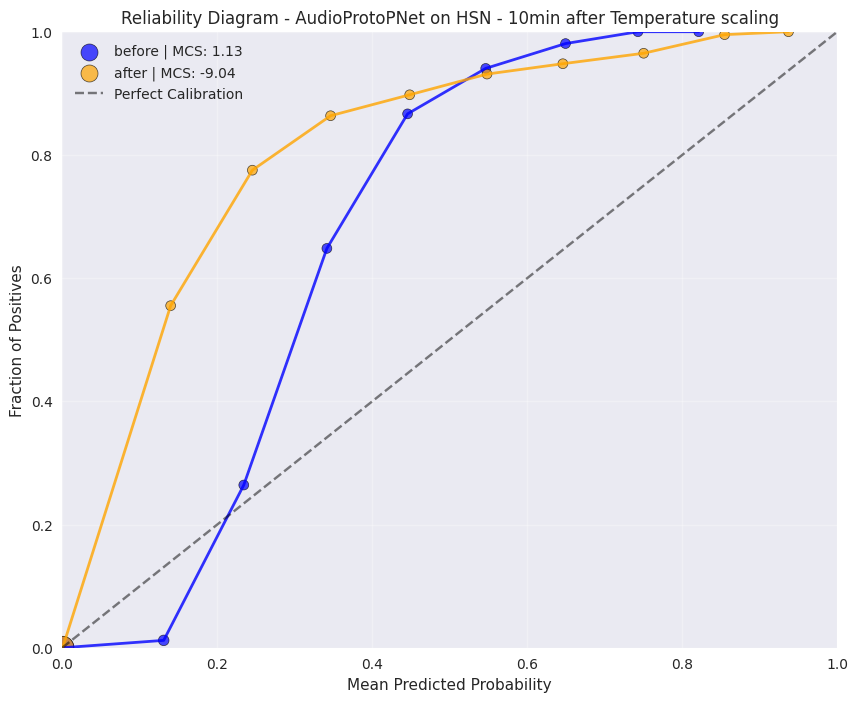

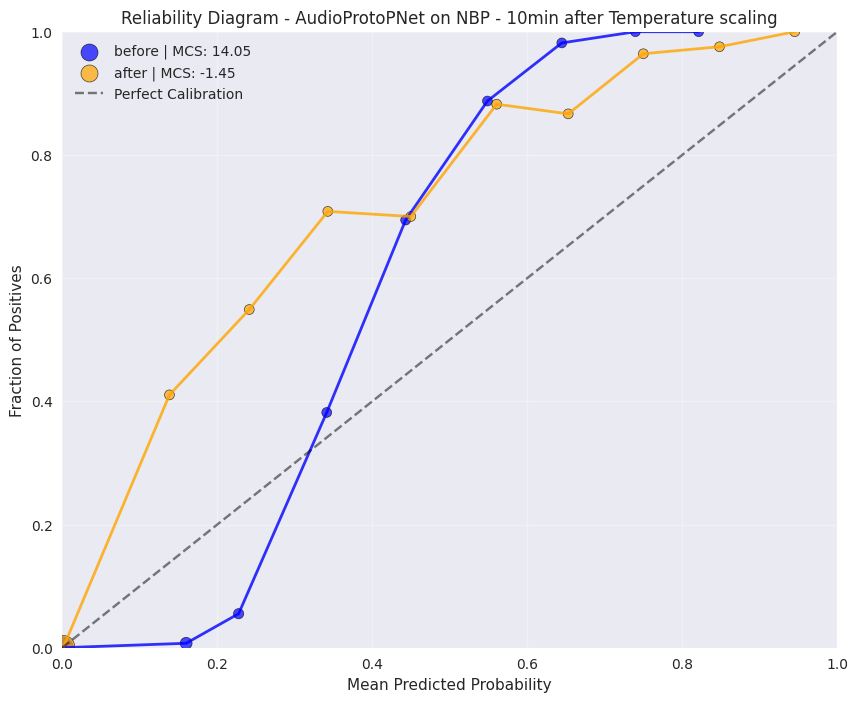

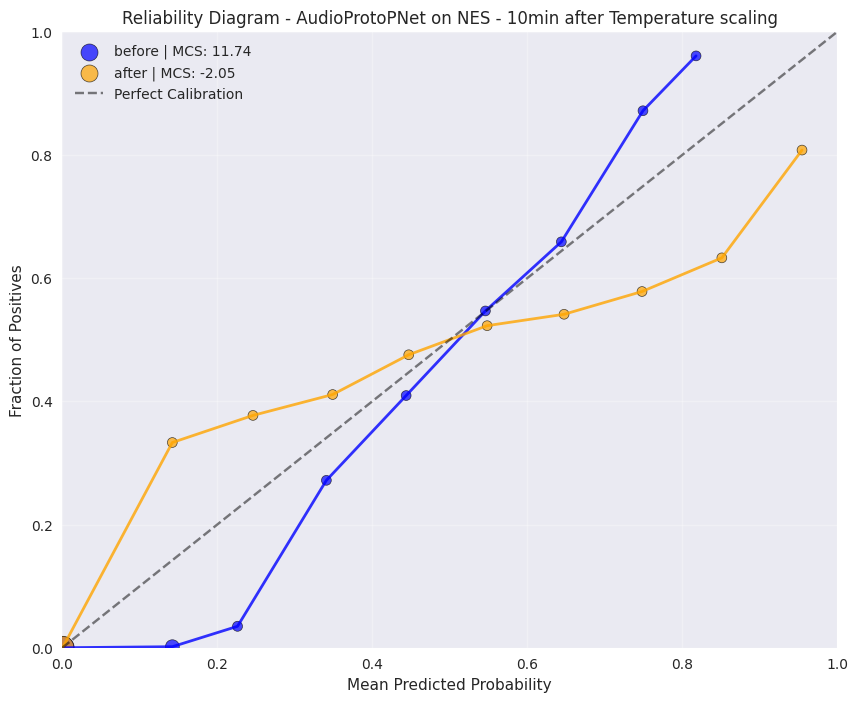

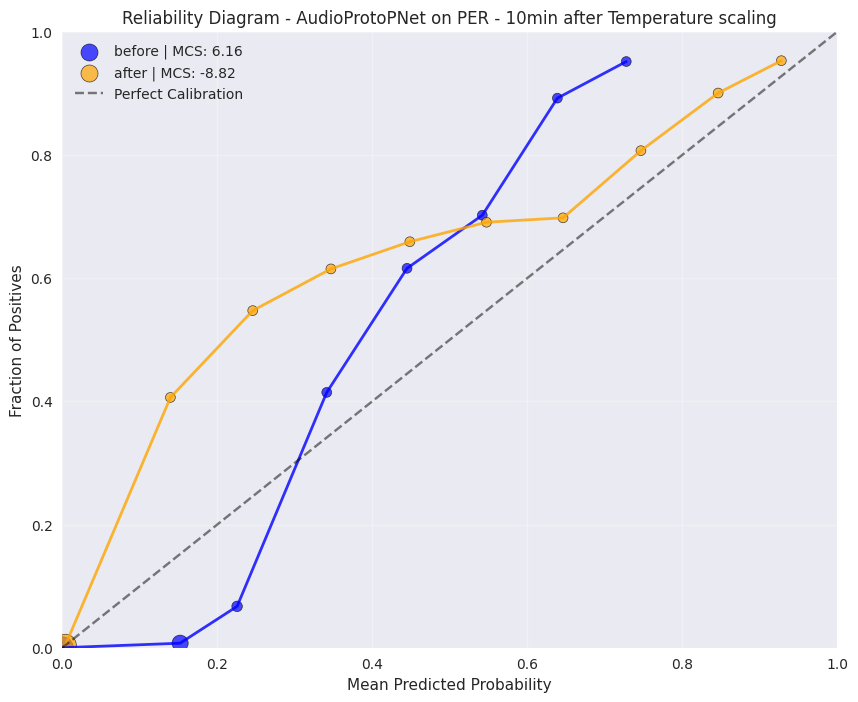

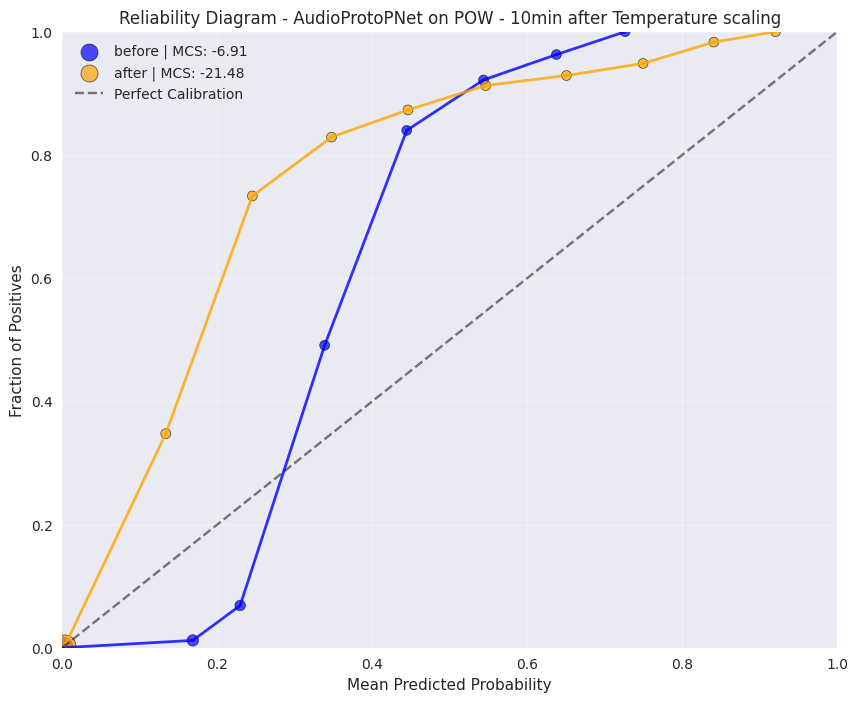

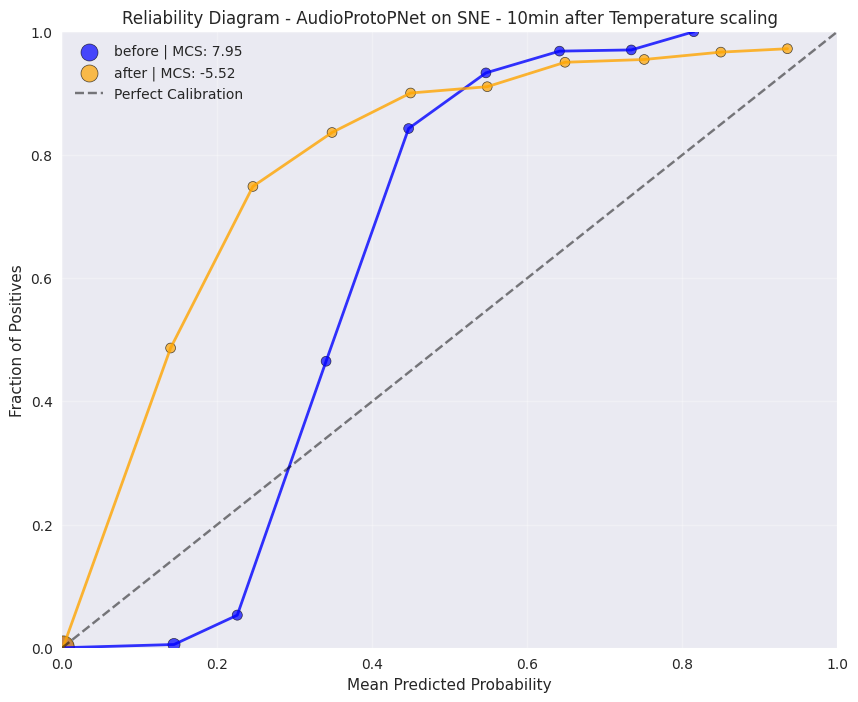

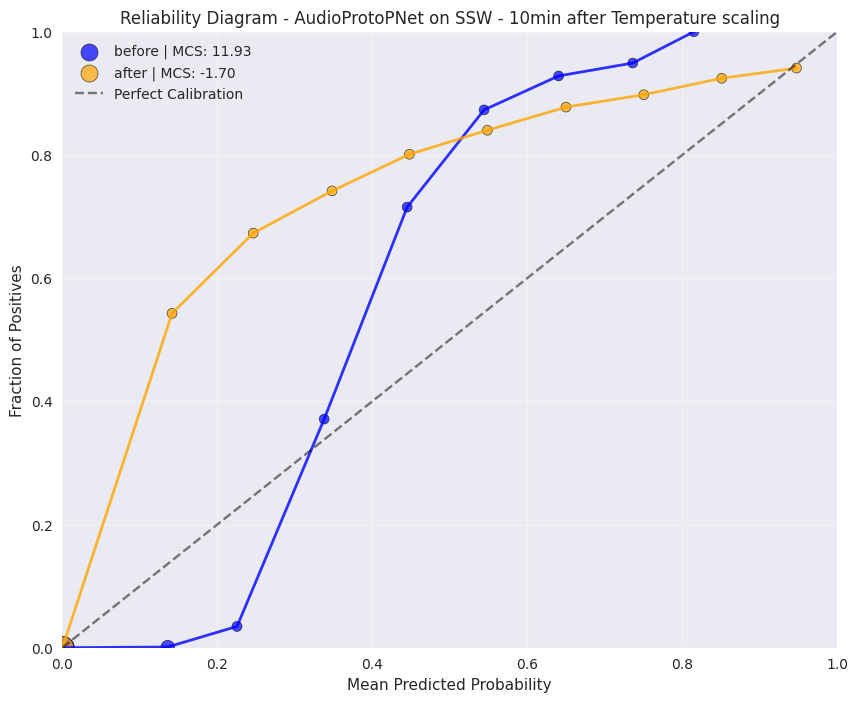

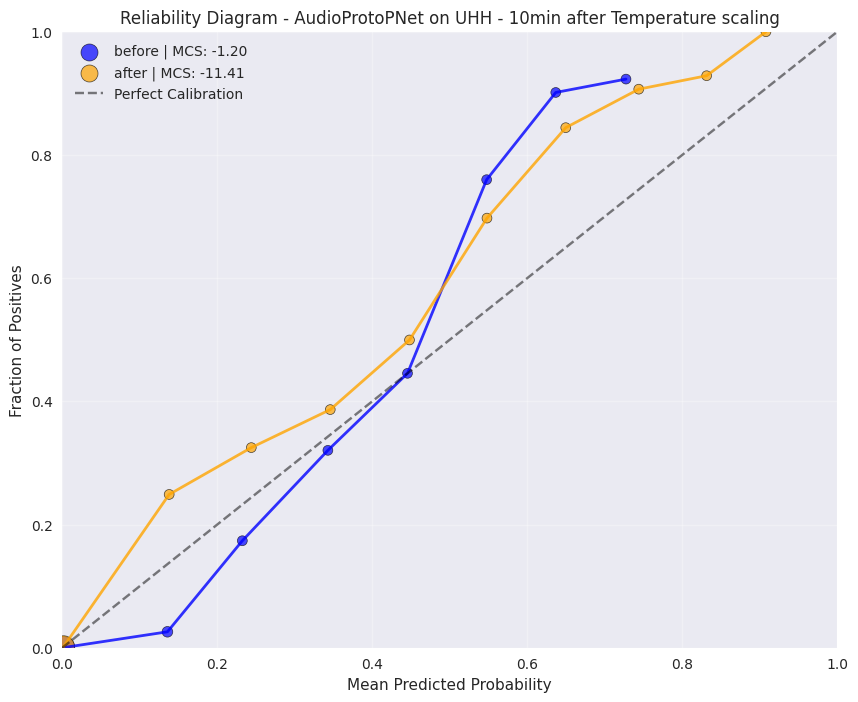

In [10]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name+"_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after Temperature scaling",
    )

### Platt scaling

In [11]:
from uncertainbird.utils.temperature_scaling import fit_per_class_platt_scaling


for ds in valid_keys:

    # compute global temperature value based on POW
    slopes, biases = fit_per_class_platt_scaling(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    # print(f"Optimal slopes: {slopes}, biases: {biases} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_platt_scaling(
        data_120[ds+'_test']["logits"], slopes, biases, model= model
    )
    print('Before platt scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After platt scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Before platt scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5552)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0062)
ECE Weighted: tensor(0.1029)
ECE Top-3: tensor(0.0978)
ECE Top-5: tensor(0.0967)
ECE Top-10: tensor(0.1122)
ECE Top-21: tensor(0.1210)
Miscalibration Score (MCS): tensor(0.0113)
ECE Under-confidence: tensor(0.0458)
ECE Over-confidence: tensor(0.0571)
After platt scaling:
Accuracy: tensor(0.9993)
cmAP: tensor(0.5552)
Precision: tensor(0.0231)
Recall: tensor(0.0078)
F1 Score: tensor(0.0103)
AUROC: tensor(0.0474)
ECE: tensor(0.0004)
ECE Weighted: tensor(0.0262)
ECE Top-3: tensor(0.0295)
ECE Top-5: tensor(0.0258)
ECE Top-10: tensor(0.0148)
ECE Top-21: tensor(0.0076)
Miscalibration Score (MCS): tensor(-0.0046)
ECE Under-confidence: tensor(0.0154)
ECE Over-confidence: tensor(0.0108)
Before platt scaling:
Accuracy: tensor(0.9967)
cmAP: tensor(0.6504)
Precision: tensor(0.0896)
Recall: tensor(0.0299)
F1 Score: ten

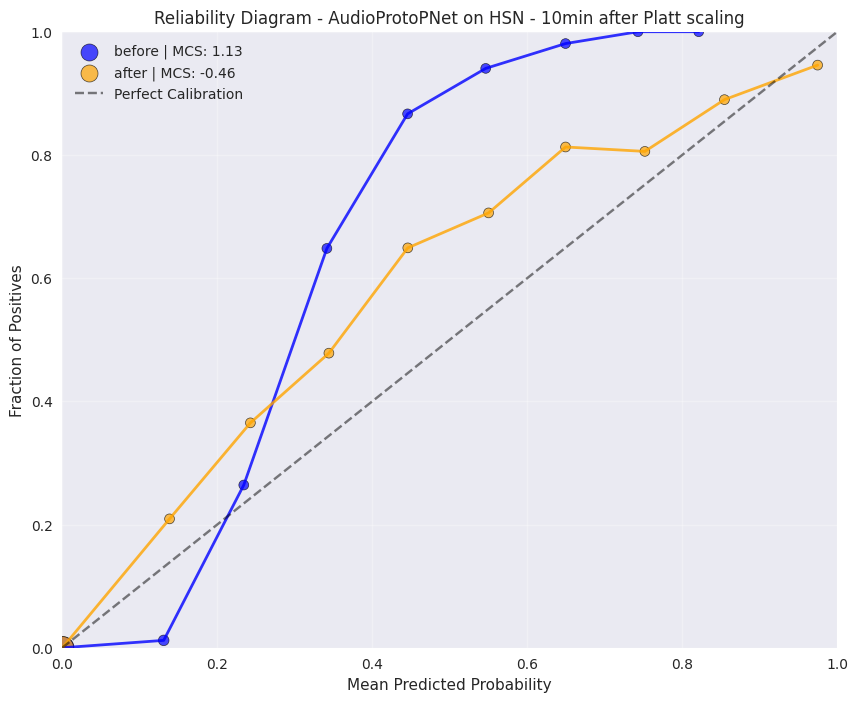

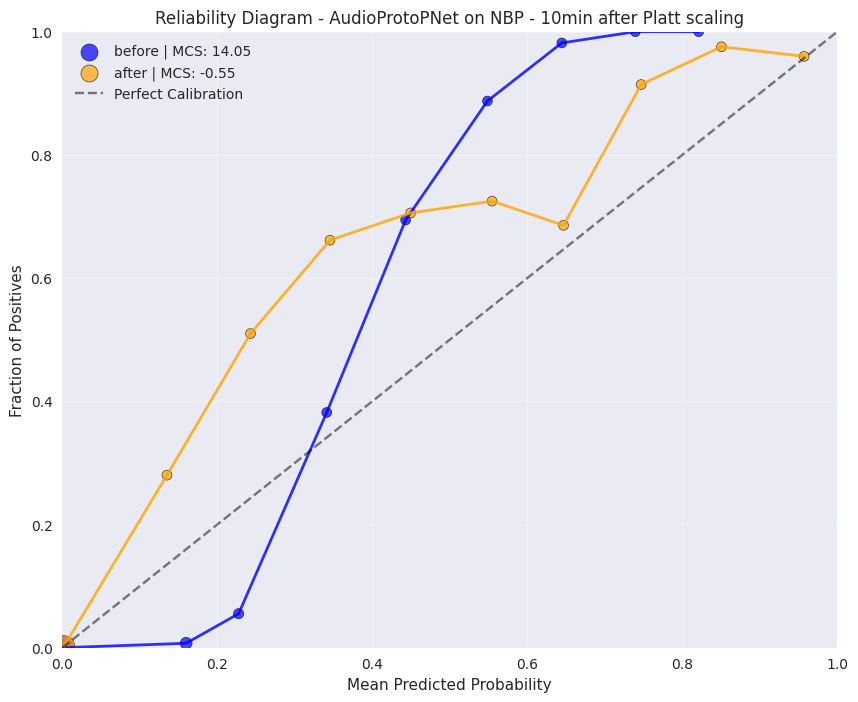

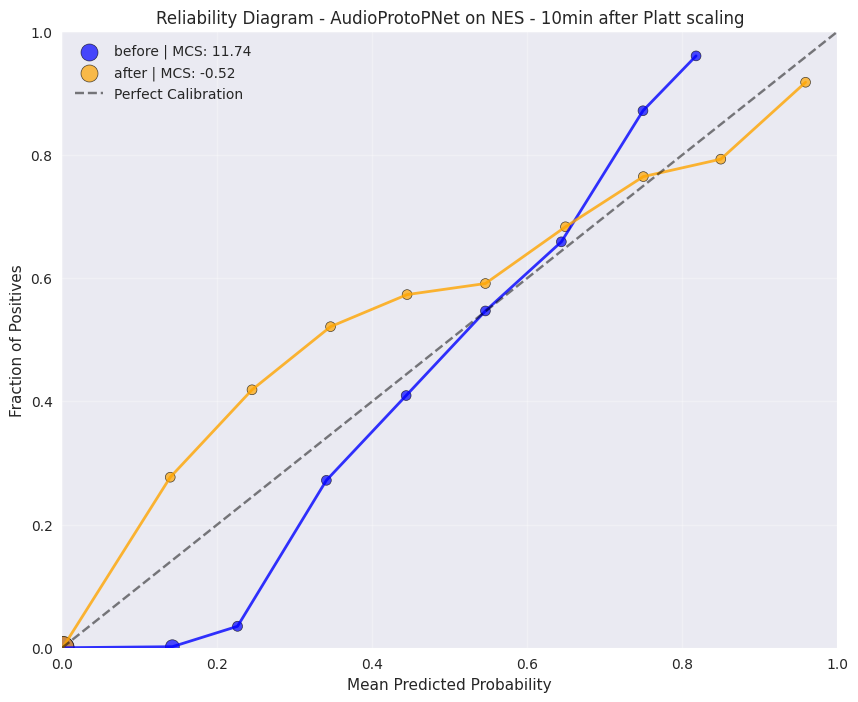

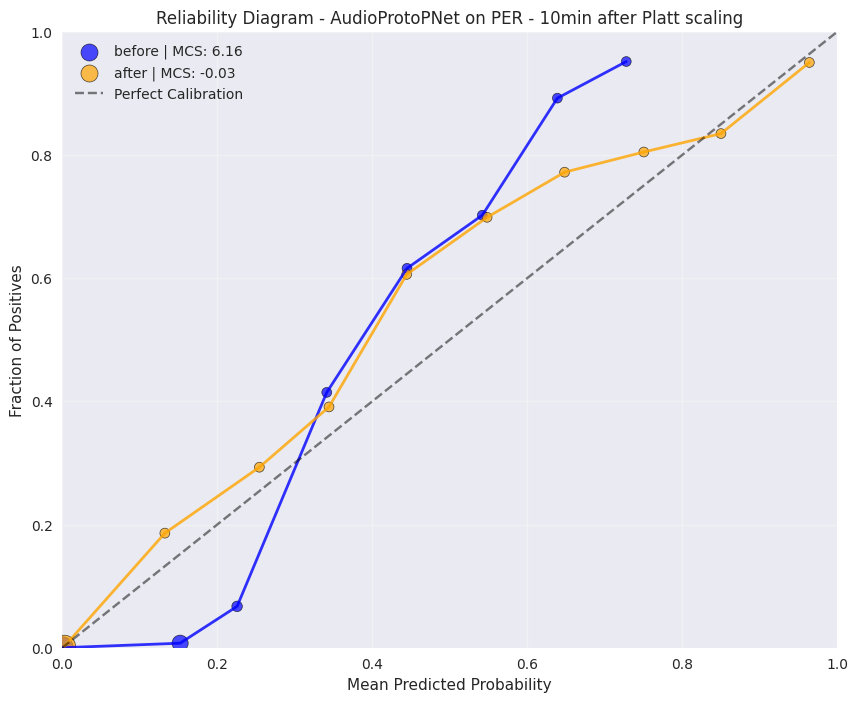

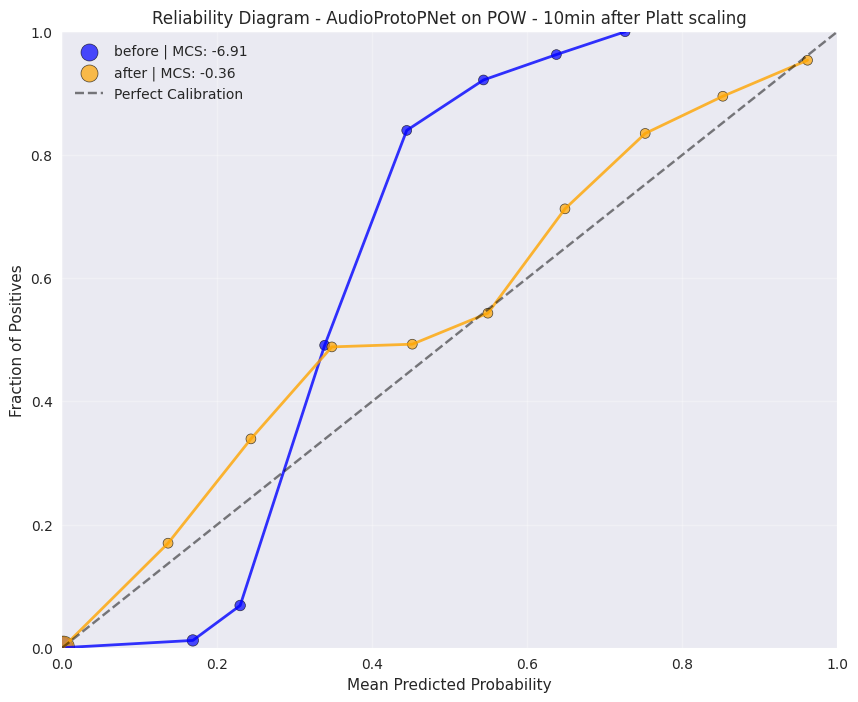

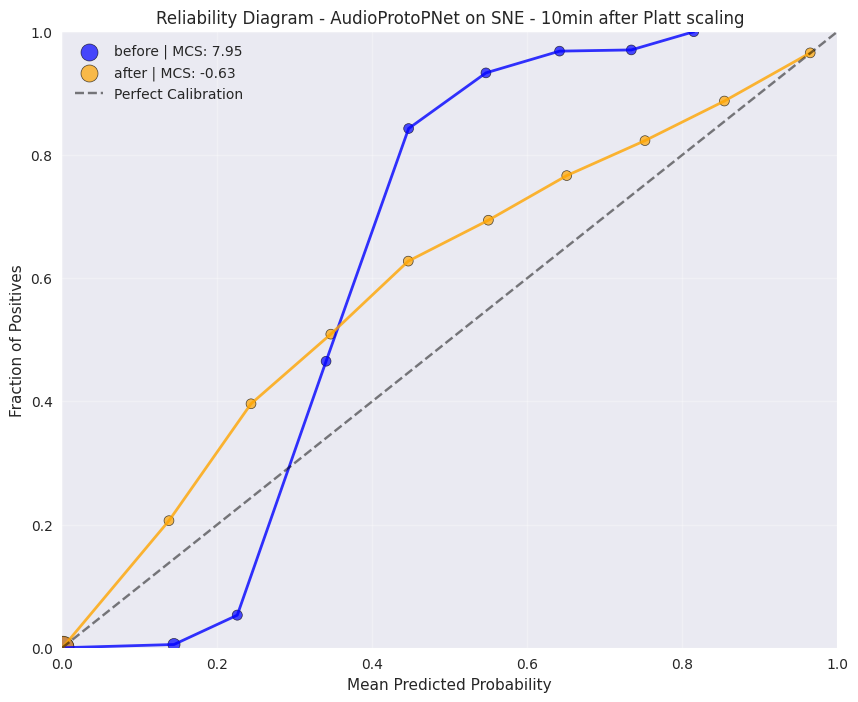

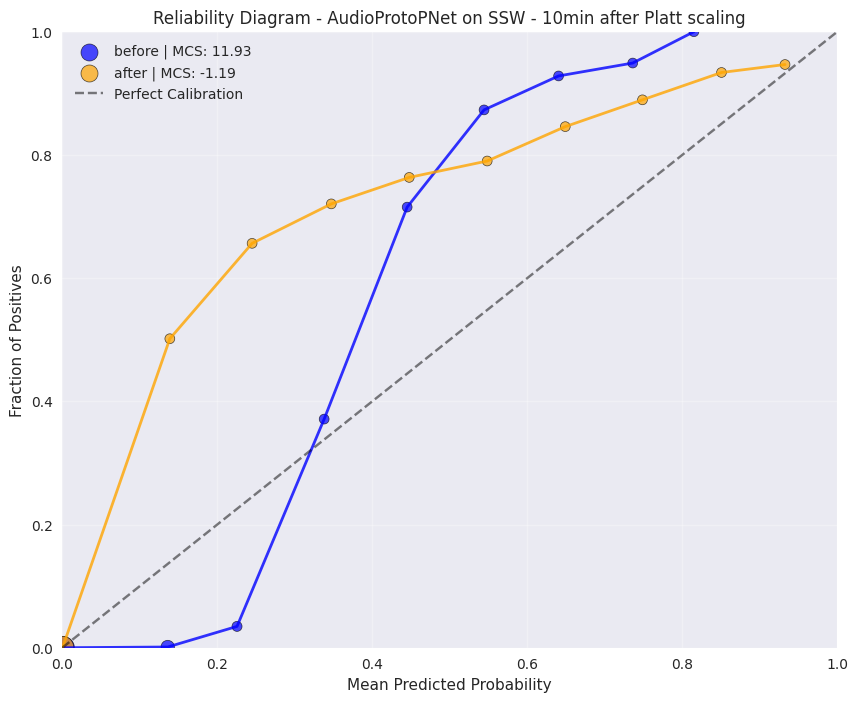

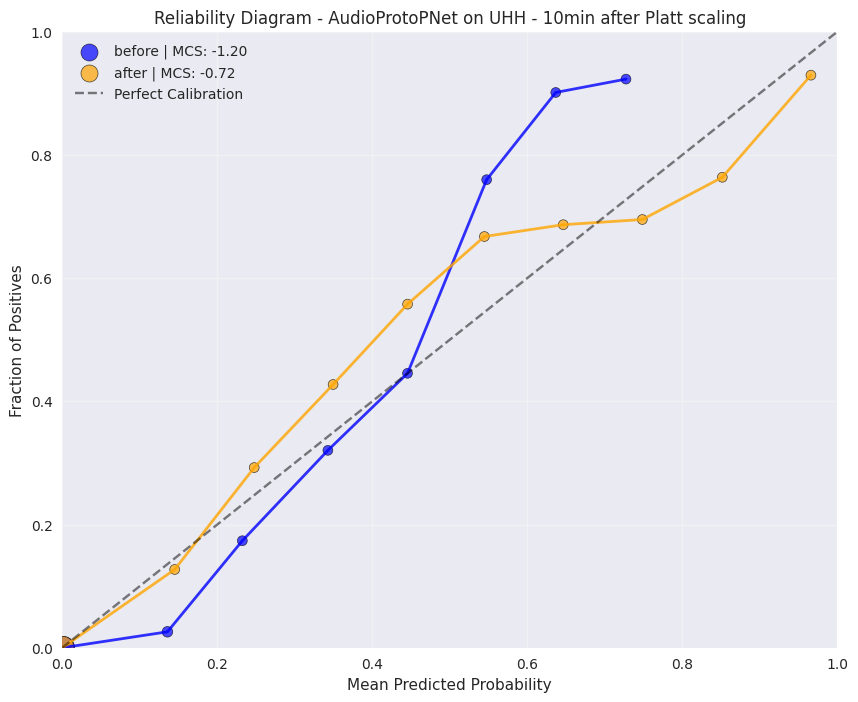

In [12]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after Platt scaling",
    )

## Parameters per class

### Temperature scaling

In [13]:
from uncertainbird.utils.temperature_scaling import fit_per_class_temperatures


for ds in valid_keys:

    print(f"Fit temperatures per class for {ds}")
    # compute global temperature value based on POW
    temperatures = fit_per_class_temperatures(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )


    data_120[ds+'_test']["predictions_ts"] = apply_temperature_scaling(
        data_120[ds+'_test']["logits"], temperatures, model= model
    )
    print('Before temperature scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After temperature scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Fit temperatures per class for HSN
Before temperature scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5552)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0062)
ECE Weighted: tensor(0.1029)
ECE Top-3: tensor(0.0978)
ECE Top-5: tensor(0.0967)
ECE Top-10: tensor(0.1122)
ECE Top-21: tensor(0.1210)
Miscalibration Score (MCS): tensor(0.0113)
ECE Under-confidence: tensor(0.0458)
ECE Over-confidence: tensor(0.0571)
After temperature scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5552)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0008)
ECE Weighted: tensor(0.0833)
ECE Top-3: tensor(0.0839)
ECE Top-5: tensor(0.0578)
ECE Top-10: tensor(0.0314)
ECE Top-21: tensor(0.0153)
Miscalibration Score (MCS): tensor(-0.0439)
ECE Under-confidence: tensor(0.0636)
ECE Over-confidence: tensor(0.0197)
Fit temperatures per class for NBP
Before temperature scaling:
Accuracy: tensor(0.9

Accuracy: tensor(0.9989)
cmAP: tensor(0.3845)
Precision: tensor(0.0940)
Recall: tensor(0.0481)
F1 Score: tensor(0.0561)
AUROC: tensor(0.2024)
ECE: tensor(0.0008)
ECE Weighted: tensor(0.0177)
ECE Top-3: tensor(0.0355)
ECE Top-5: tensor(0.0271)
ECE Top-10: tensor(0.0171)
ECE Top-21: tensor(0.0114)
Miscalibration Score (MCS): tensor(-0.0088)
ECE Under-confidence: tensor(0.0132)
ECE Over-confidence: tensor(0.0045)
Fit temperatures per class for PER
Before temperature scaling:
Accuracy: tensor(0.9944)
cmAP: tensor(0.3189)
Precision: tensor(0.1523)
Recall: tensor(0.0231)
F1 Score: tensor(0.0360)
AUROC: tensor(0.2605)
ECE: tensor(0.0487)
ECE Weighted: tensor(0.1512)
ECE Top-3: tensor(0.1406)
ECE Top-5: tensor(0.1326)
ECE Top-10: tensor(0.1391)
ECE Top-21: tensor(0.1450)
Miscalibration Score (MCS): tensor(0.0616)
ECE Under-confidence: tensor(0.0448)
ECE Over-confidence: tensor(0.1064)
After temperature scaling:
Accuracy: tensor(0.9944)
cmAP: tensor(0.3189)
Precision: tensor(0.1523)
Recall: ten

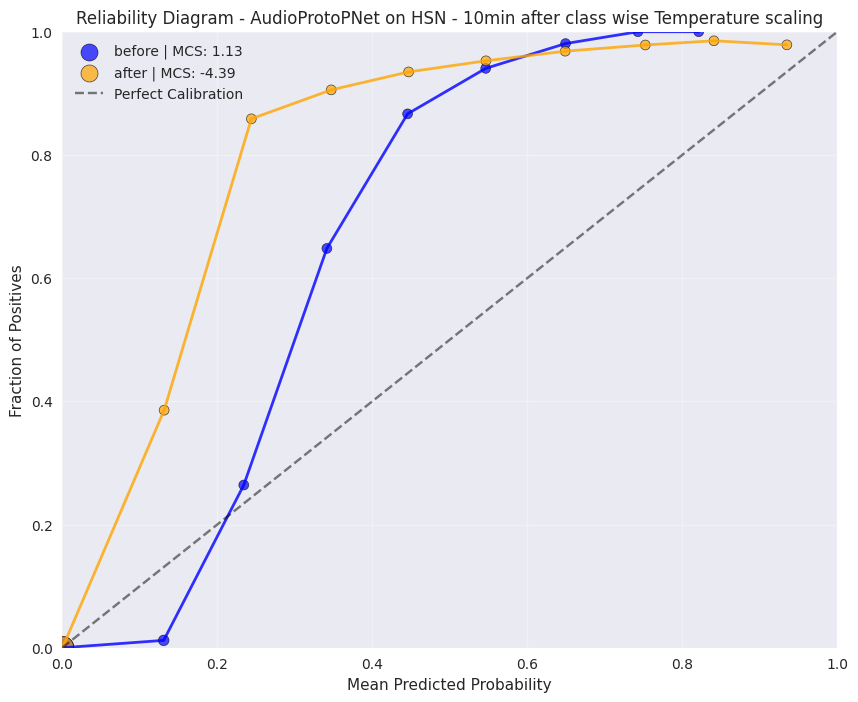

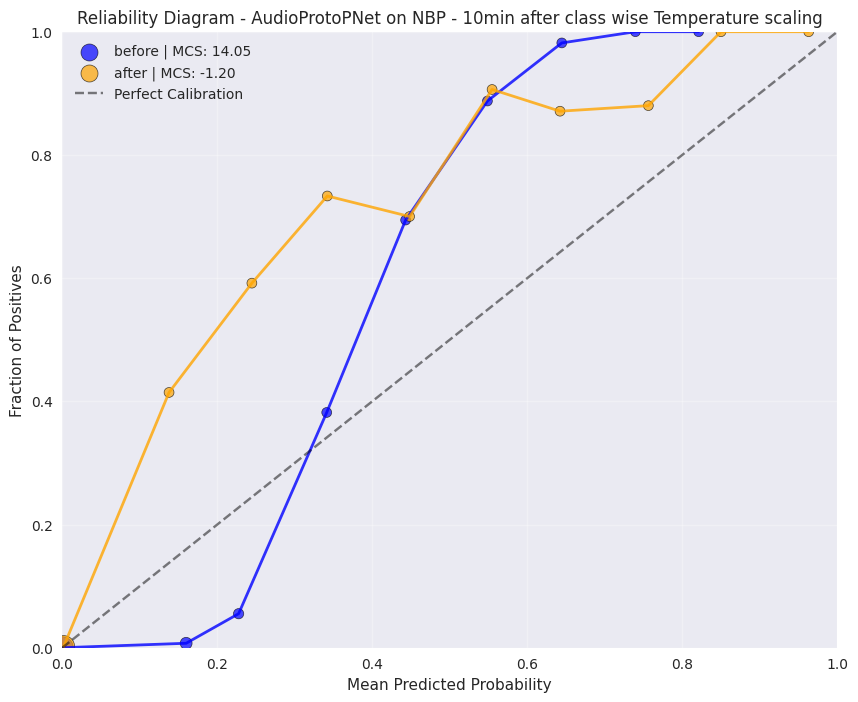

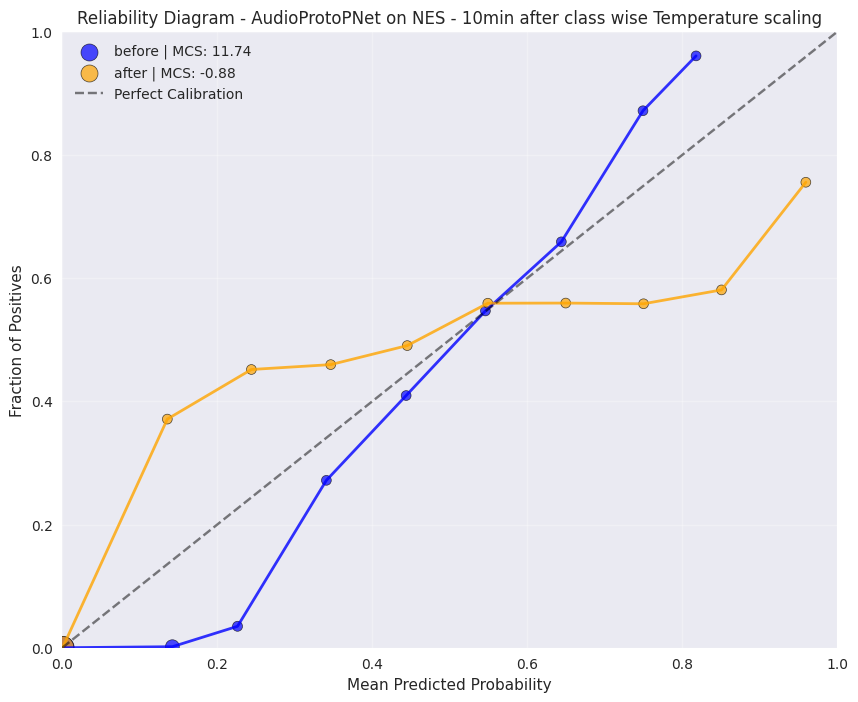

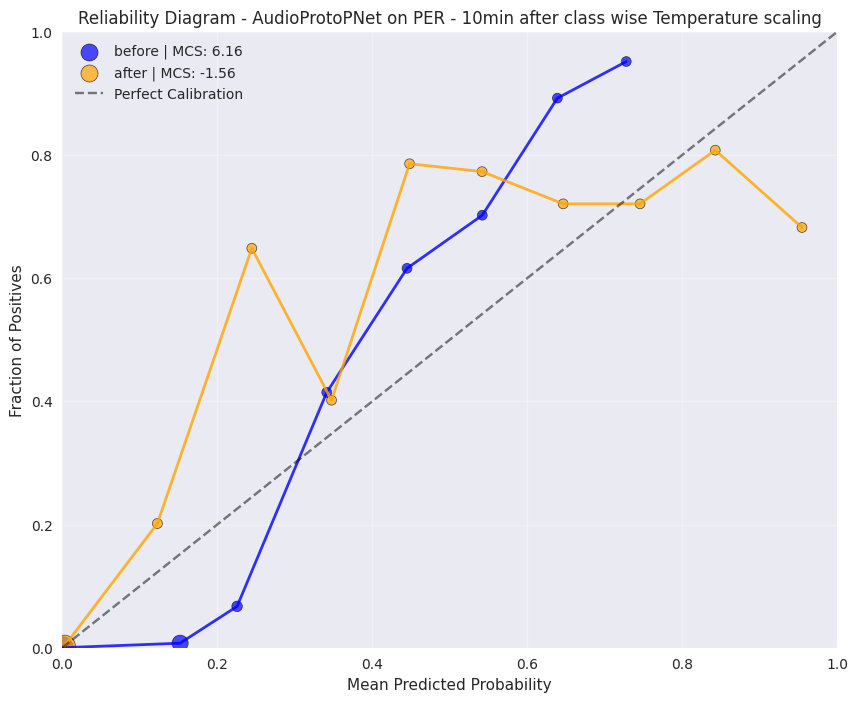

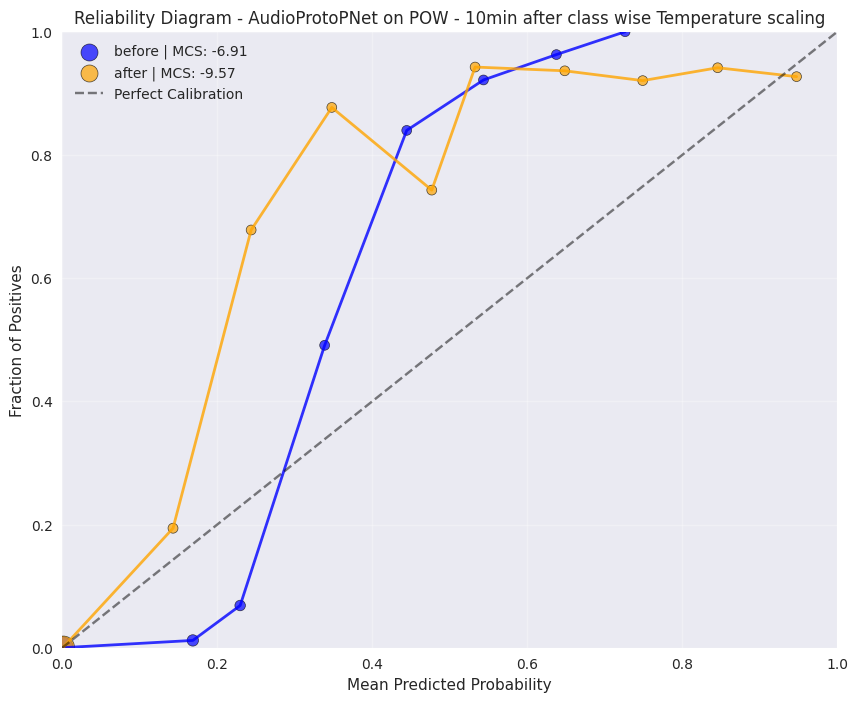

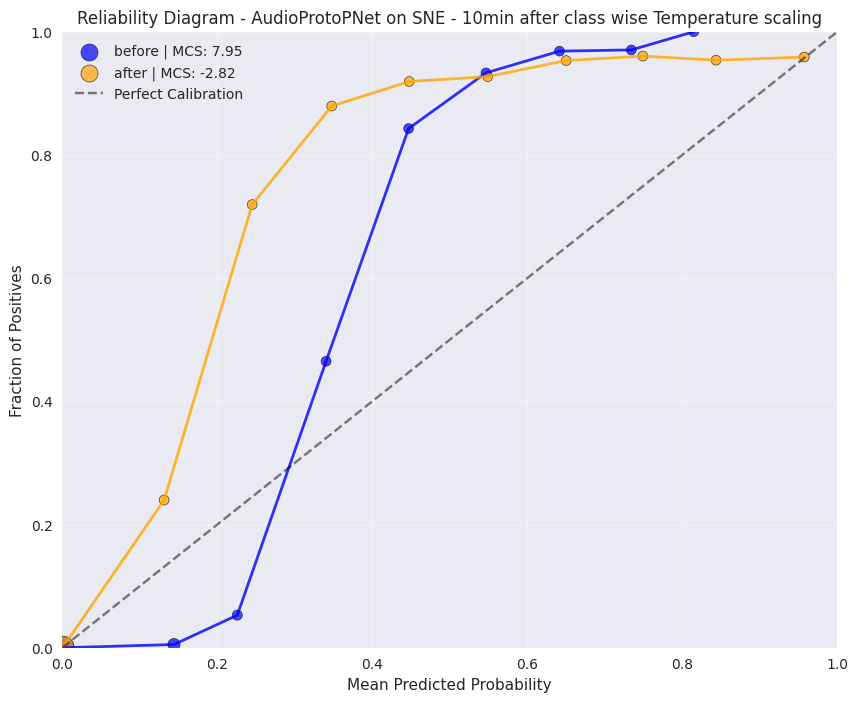

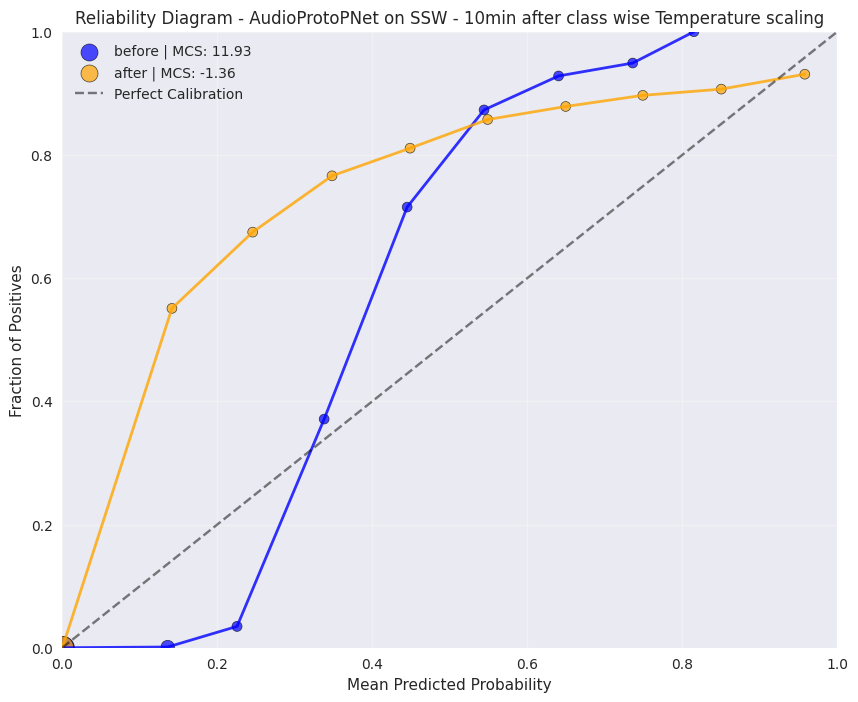

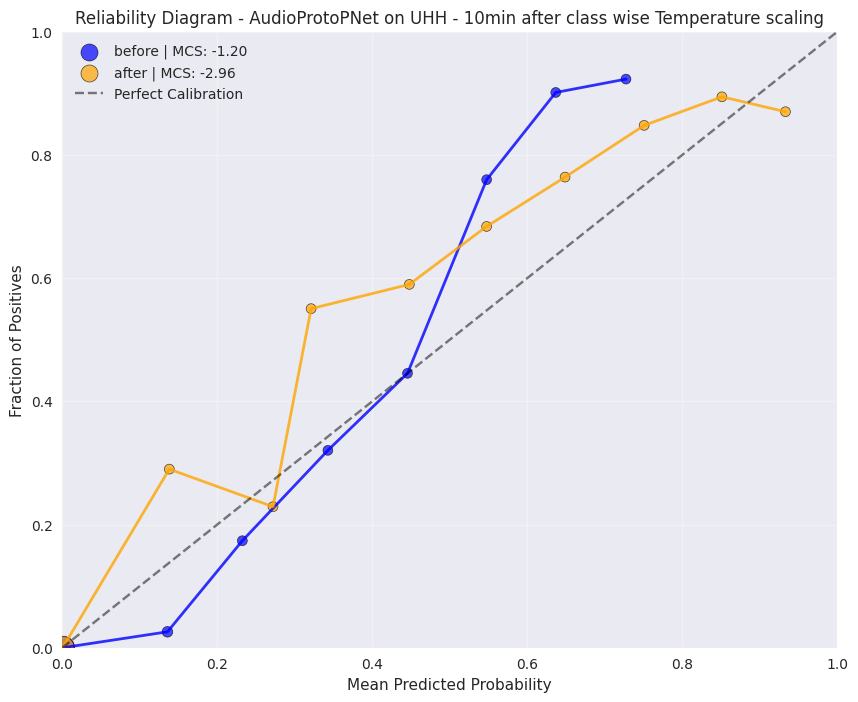

In [14]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after class wise Temperature scaling",
    )

### Platt scaling

In [15]:
for ds in valid_keys:

    # compute global temperature value based on POW
    slopes, biases = fit_per_class_platt_scaling(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    # print(f"Optimal slopes: {slopes}, biases: {biases} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_platt_scaling(
        data_120[ds+'_test']["logits"], slopes, biases, model= model
    )
    print('Before platt scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After platt scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Before platt scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5552)
Precision: tensor(0.0285)
Recall: tensor(0.0087)
F1 Score: tensor(0.0121)
AUROC: tensor(0.0474)
ECE: tensor(0.0062)
ECE Weighted: tensor(0.1029)
ECE Top-3: tensor(0.0978)
ECE Top-5: tensor(0.0967)
ECE Top-10: tensor(0.1122)
ECE Top-21: tensor(0.1210)
Miscalibration Score (MCS): tensor(0.0113)
ECE Under-confidence: tensor(0.0458)
ECE Over-confidence: tensor(0.0571)
After platt scaling:
Accuracy: tensor(0.9993)
cmAP: tensor(0.5552)
Precision: tensor(0.0231)
Recall: tensor(0.0078)
F1 Score: tensor(0.0103)
AUROC: tensor(0.0474)
ECE: tensor(0.0004)
ECE Weighted: tensor(0.0262)
ECE Top-3: tensor(0.0295)
ECE Top-5: tensor(0.0258)
ECE Top-10: tensor(0.0148)
ECE Top-21: tensor(0.0076)
Miscalibration Score (MCS): tensor(-0.0046)
ECE Under-confidence: tensor(0.0154)
ECE Over-confidence: tensor(0.0108)
Before platt scaling:
Accuracy: tensor(0.9967)
cmAP: tensor(0.6504)
Precision: tensor(0.0896)
Recall: tensor(0.0299)
F1 Score: ten

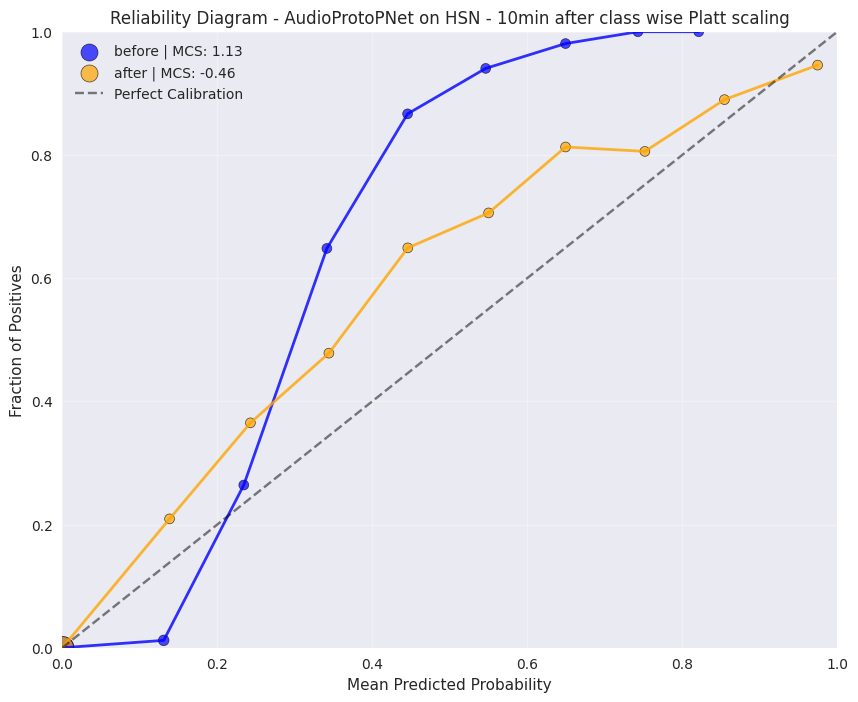

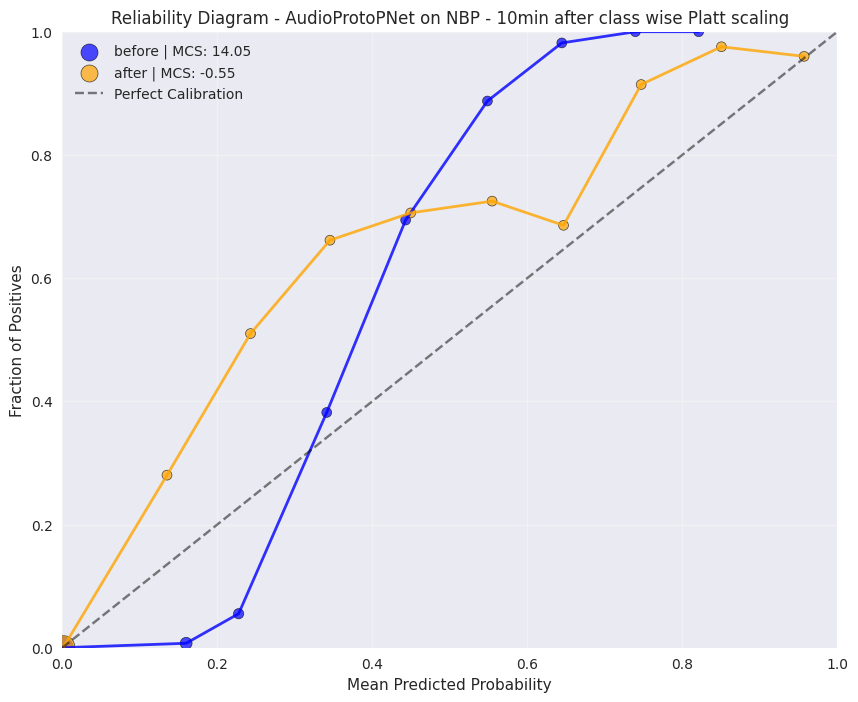

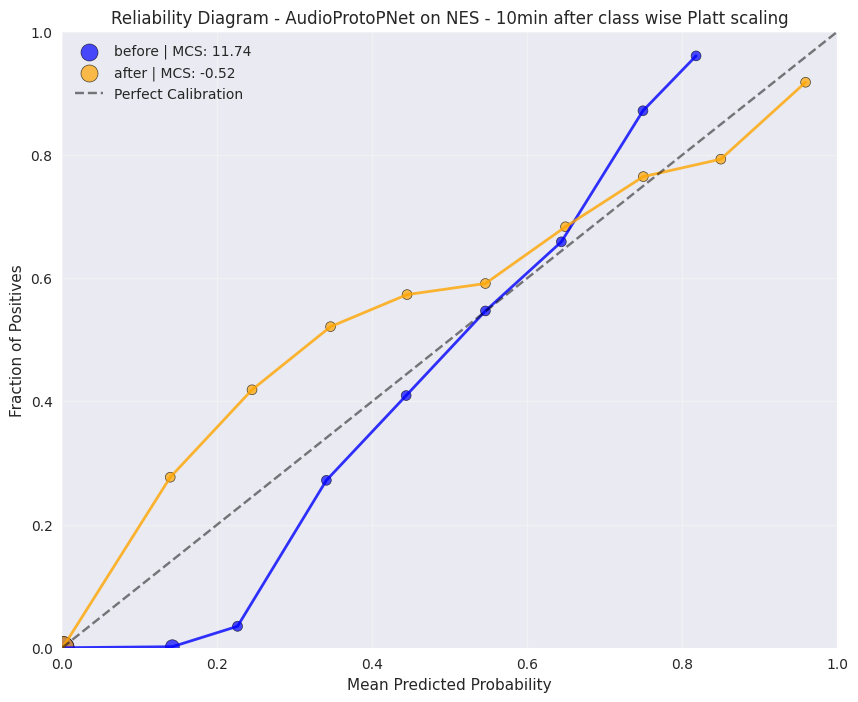

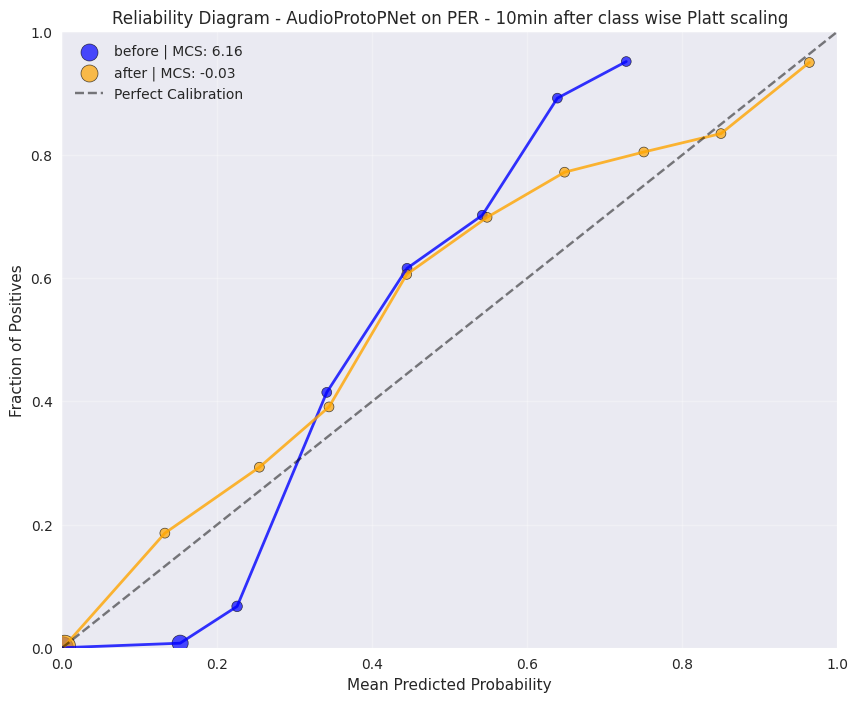

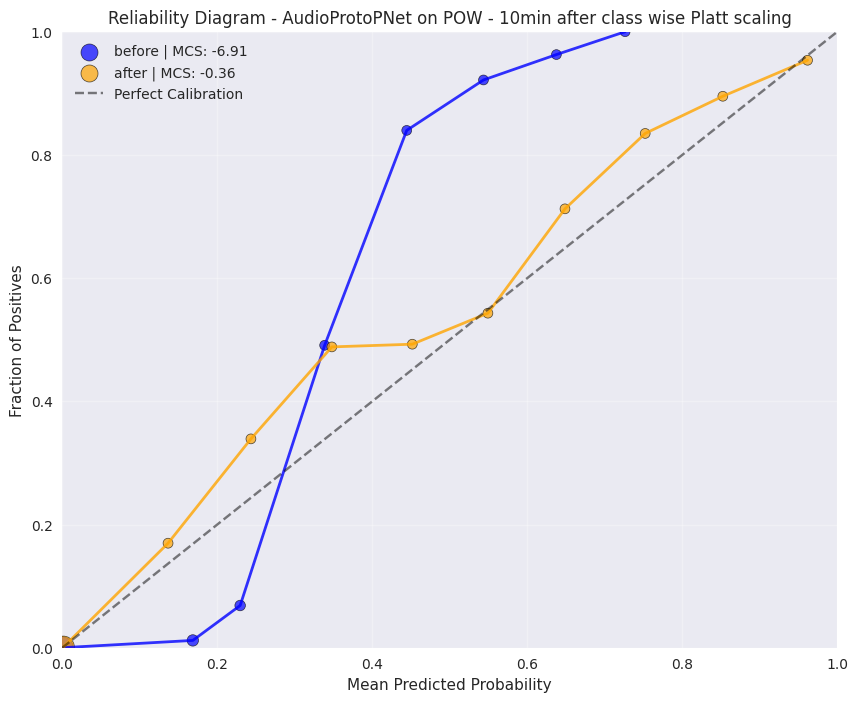

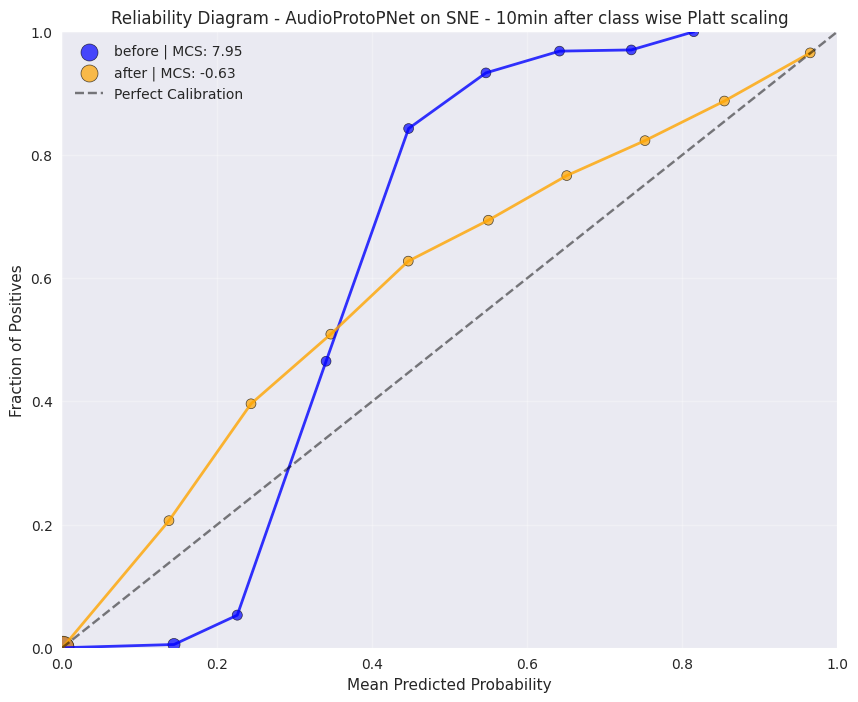

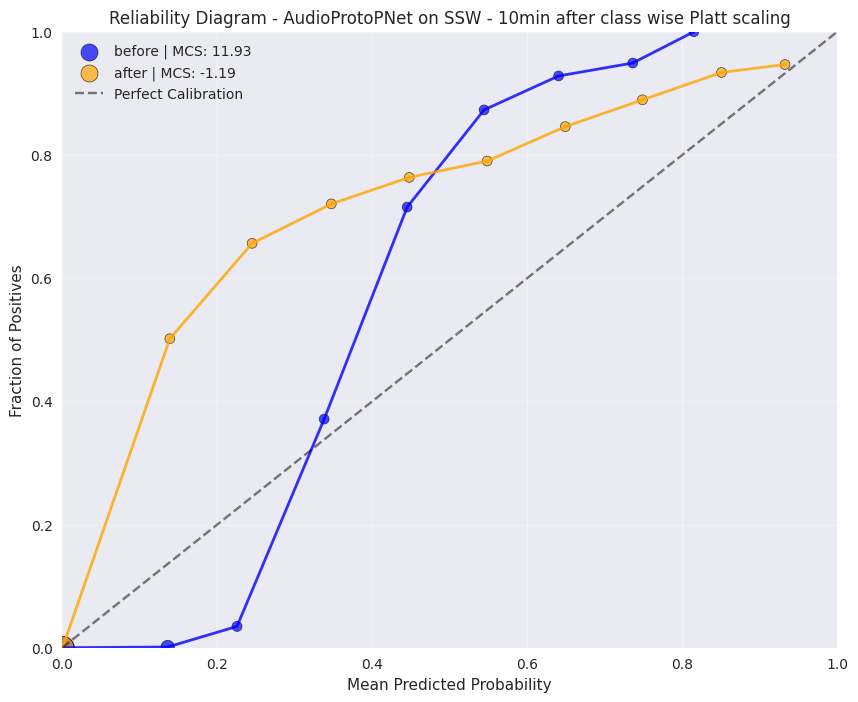

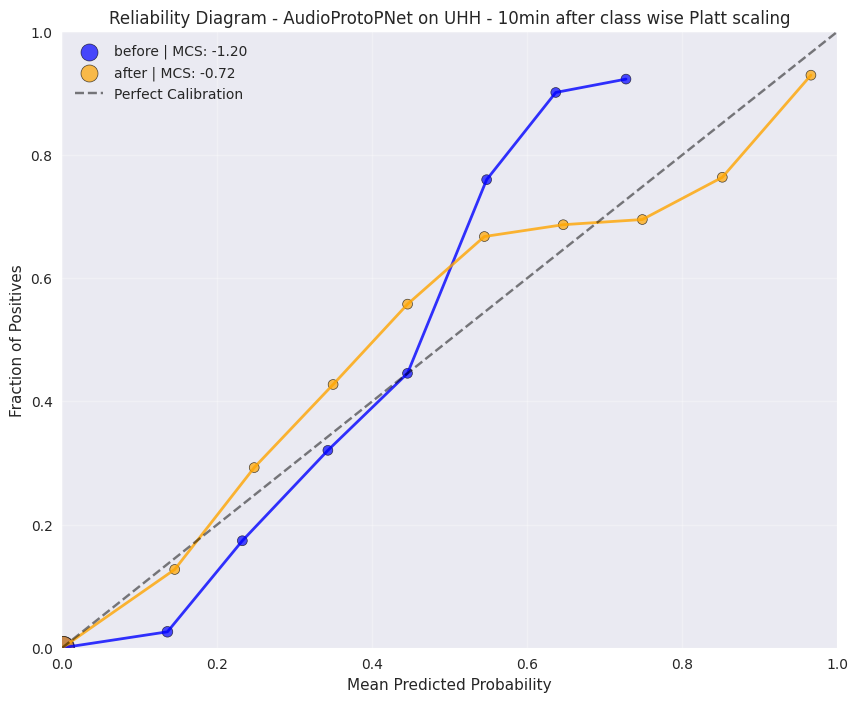

In [16]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after class wise Platt scaling",
    )